In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
batch_size = 500000 
split = 0.7
# rolling_window = 6000

In [ ]:
data = pd.read_csv('train_clean.csv')

In [ ]:
def add_rolling_features(data):
#     data['r_mean_6000'] = data['signal'].rolling(6000).mean()
    data['r_mean_3000'] = data['signal'].rolling(3000).mean()
    data['r_stdev_5'] = data['signal'].rolling(5).std()
    data['r_ema_20'] = data['signal'].ewm(span=20, adjust=False).mean()
    data['r_ema_5'] = data['signal'].ewm(span=5, adjust=False).mean()
    return data

In [ ]:
data = add_rolling_features(data)

In [ ]:
labels = np.array(data['open_channels'])

feature_cols = ['signal', 
#                 'r_mean_6000', 
                'r_mean_3000',
                'r_stdev_5',
                'r_ema_20',
                'r_ema_5',
               ]
features= data[feature_cols]

feature_list = list(data.columns)
features = np.array(features)

In [ ]:
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [348]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (3750000, 5)
Training Labels Shape: (3750000,)
Testing Features Shape: (1250000, 5)
Testing Labels Shape: (1250000,)


In [349]:
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

In [350]:
clf = LGBMClassifier(max_depth=4)
grid_values = {'n_estimators':range(200, 600, 80), 'num_leaves':range(20, 60, 10)}
model = GridSearchCV(clf, param_grid = grid_values, scoring = 'f1_macro')

In [ ]:
model.fit(train_features, train_labels)

In [335]:
# Extract feature importances

fi = pd.DataFrame({'feature': list(feature_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(20)

,feature,importance
0,signal,6316
1,r_mean_3000,3463
4,r_ema_5,2380
3,r_ema_20,2332
2,r_stdev_5,1951


In [336]:
# Predicting the Test set results
predictions = model.predict(test_features)

In [337]:
# Making the Confusion Matrix
pd.crosstab(test_labels, predictions, rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9,10
Actual,,,,,,,,,,,
0,308913,767,58,15,0,0,0,0,0,0,0
1,805,244127,1637,154,1,0,0,0,0,0,0
2,81,1212,134677,2558,27,15,0,0,0,0,0
3,25,115,2524,163364,1449,39,9,0,0,0,0
4,1,1,14,1536,97207,2009,44,12,0,0,0
5,0,0,3,28,1658,65264,2268,49,9,0,0
6,0,0,0,25,62,2092,40945,3984,0,0,0
7,0,0,0,0,20,64,3233,58387,4241,0,0
8,0,0,0,0,0,29,0,4004,54753,2660,0


In [338]:
accuracy_score(test_labels, predictions)

0.963824

In [339]:
f1_score(test_labels, predictions, average='macro')

0.9294086905990759

In [90]:
sub_data = pd.read_csv('test_clean.csv')

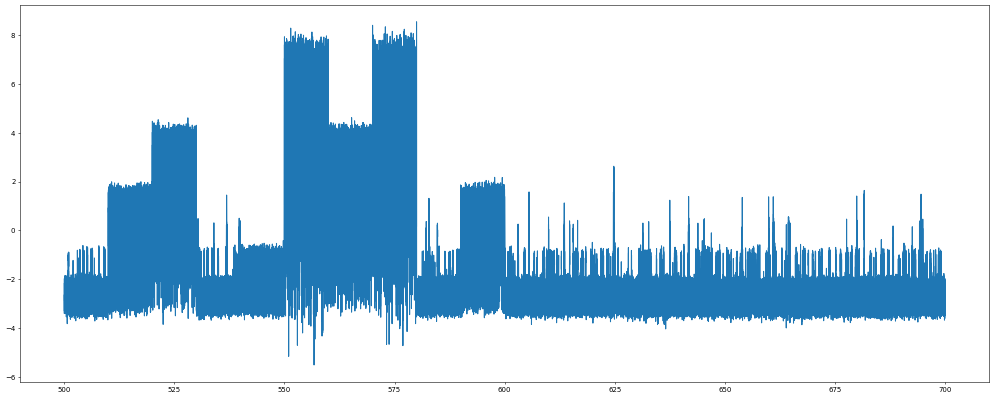

In [91]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(sub_data['time'], sub_data['signal'])

In [92]:
sub_data.head()

,time,signal
0,500.0001,-2.649831
1,500.0002,-2.849463
2,500.0003,-2.860094
3,500.0004,-2.435126
4,500.0005,-2.615657


In [93]:
sub_data = add_rolling_features(sub_data)

In [94]:
sub_features = sub_data[feature_cols]
sub_features = np.array(sub_features)
sub_features = sc.transform(sub_features)

In [95]:
sub_predictions = model.predict(sub_features)

In [96]:
sub_data['open_channels'] = sub_predictions

In [97]:
sub_data.sample(n=10, random_state=10)

,time,signal,r_mean_6000,r_mean_3000,r_mean_1500,r_mean_500,r_mean_100,r_stdev_6000,r_stdev_3000,r_stdev_1500,r_stdev_500,r_stdev_100,r_ema_6000,r_ema_3000,r_ema_1500,r_ema_500,r_ema_100,open_channels
690084,569.0085,2.548812,1.617215,1.655740,1.826172,1.477058,2.775691,1.335266,1.324558,1.309409,1.598022,0.974686,1.607587,1.663162,1.715324,1.919816,2.796583,4
333871,533.3872,-2.214700,-2.697615,-2.693129,-2.680702,-2.685932,-2.643573,0.241155,0.241172,0.238087,0.239879,0.237555,-2.662905,-2.685251,-2.684556,-2.678644,-2.660092,0
162719,516.2720,0.711499,-0.029050,-0.066309,-0.050756,0.005584,-0.390497,0.992616,0.998622,1.027338,1.094261,0.994628,-0.053926,-0.071633,-0.105197,-0.267683,-0.689915,3
1571186,657.1187,-2.693600,-2.529856,-2.628932,-2.520972,-2.710876,-2.689248,0.516508,0.412794,0.511130,0.246144,0.255313,-2.572728,-2.596274,-2.602242,-2.682508,-2.721151,0
528149,552.8150,4.319500,3.113599,3.813286,4.282319,4.039380,4.479507,1.933091,1.717969,1.550524,1.447406,1.383561,3.502942,3.806353,4.062300,4.225854,4.598256,8
505510,550.5511,3.882600,3.293421,3.653113,4.246930,3.473307,2.860352,2.332678,1.819440,1.647403,1.539136,1.377194,2.877921,3.703282,3.901660,3.525175,3.153693,8
910611,591.0612,-0.250200,-0.048391,-0.075796,-0.034673,-0.493756,-0.182150,0.947552,0.973664,0.966004,1.111563,0.971266,-0.165268,-0.119212,-0.180693,-0.316731,-0.085592,2
740722,574.0723,1.917263,3.409068,3.661732,4.062380,3.620477,3.014097,1.790816,1.757461,1.654527,1.489275,1.352119,3.536685,3.747530,3.887662,3.640657,3.060651,6
1615440,661.5441,-2.745400,-2.292026,-2.563798,-2.730449,-2.740427,-2.742755,0.838029,0.491990,0.251079,0.243941,0.250824,-2.494436,-2.572097,-2.664355,-2.733719,-2.752854,0
687279,568.7280,2.127203,1.437659,1.687293,1.733196,1.821016,2.505324,1.326633,1.313409,1.336065,1.278065,0.926013,1.571235,1.659807,1.748393,2.008392,2.348597,4


In [98]:
out_cols = ['time', 'open_channels']
out_data = sub_data[out_cols]

In [99]:
out_data.to_csv('submission.csv', index=False, float_format='%.4f')